# Quadcopter modelling

The quadcopter model from [1] is adopted. A schematic (adapted from [2]) is shown below.

<img src="../media/quadrotor.png" alt="pendulum" style="width: 900px;"/>

### Description of the quadcopter


The quadcopter is assumed to have a symmetric structure with its arms aligned with the x- and y-axis of the body frame. The inertia matrix $\mathbf{I}$ of the quadcopter is given by

$$ \mathbf{I} = \begin{bmatrix} I_{xx} & 0 & 0 \\ 0 & I_{yy} & 0 \\ 0 & 0 & I_{zz} \end{bmatrix}, $$

and the distance between the quadcopter centre-of-mass and each rotor is $l$.


The linear position of the quadcopter in the world frame is described by $\boldsymbol\xi = [x,y,z]^T$ and its orienation in the world frame is described by the ZYX Euler angles $\boldsymbol\eta = [\phi, \theta, \psi]^T$. The rotation matrix from the body frame to the world frame is given by
 

$$ \mathbf{R} = \begin{bmatrix} c\psi c\theta & c\psi s\theta s\phi - s\psi c\phi & c\psi s\theta c\phi + s\psi s\phi \\ s\psi c\theta & s\psi s\theta s\phi + c\psi c\phi & s\psi s\theta c\phi - c\psi s\phi \\ -s\theta & c\theta s\phi & c\theta c\phi \end{bmatrix}, $$

where $c\psi = \cos(\psi)$, $s\psi = \sin(\psi)$, $c\theta = \cos(\theta)$, $s\theta = \sin(\theta)$, $c\phi = \cos(\phi)$, and $s\phi = \sin(\phi)$.

The angular velocity in the body frame is $\boldsymbol\nu = [p, q , r]^T.$ The transformation matrix for angular velocities from the body frame to the world frame is given by

$$ \boldsymbol{\nu} = W_{\eta}\, \dot{\boldsymbol{\eta}}, $$

where,

$$ \mathbf{W}_{\eta} = \begin{bmatrix} 1 & 0 & -s\theta \\ 0 & c\phi & s\phi c\theta \\ 0 & -s\phi & c\phi c\theta \end{bmatrix}, $$

and the transformation for angular velocities from the world frame to the body frame is given by:

$$ \dot{\boldsymbol{\eta}} = \mathbf{W}_{\eta}^{-1} \, \boldsymbol{\nu} $$



### Dynamics

The control vector is:

$$ u = [\omega_1^2, \omega_2^2, \omega_3^2, \omega_4^2]^T $$

where $\omega_i$ is the angular velocity of the $i$-th propeller.

The force produced by the propellers is given by
$$ f_i = k \,\omega_i^2 = k\,u_i $$
and the torques produced by the propellers are given by
$$ \tau_i = b \, \omega_i^2 = b\,u_i$$
where $k$ and $b$ are constants.

In the body frame, the total force $\mathbf{T}_B$ and torques $\boldsymbol\tau_B$ are given by

$$ \mathbf{T}_B = \begin{bmatrix} 0 \\ 0 \\ \sum_{i=1}^4 f_i \end{bmatrix} $$

and 

$$ \boldsymbol\tau_B = \begin{bmatrix} l\, k\, (-u_2 + u_4) \\ l\, k\, (-u_1 + u_3) \\ \,b\,(-u_1 + u_2 - u_3 + u_4) \end{bmatrix} $$
where $l$ is the distance from the center of the quadcopter to the center of the propellers.


The equation of motion are for the linear position is then given by:

$$ m\ddot{\boldsymbol\xi} = \mathbf{G} + \mathbf{R}\mathbf{T}_B, $$

where $ \mathbf{G} = [0, 0, -g]^T.$ The equation of motion for the angular velocity in the body frame is

$$ \mathbf{I}\dot{\boldsymbol\nu} + \boldsymbol\nu \times \mathbf{I}\boldsymbol\nu = \boldsymbol{\tau}_B. $$

The dynamics equation for $\boldsymbol\eta$ are obtained by attracting the body-frame accelerations $\dot{\boldsymbol{\nu}}$ to the world frame:


$$ \ddot{\boldsymbol{\eta}} = \frac{d}{dt}\left(\mathbf{W}_{\eta}^{-1}\,{\boldsymbol{\nu}}\right) = \frac{d}{dt}\left(\mathbf{W}_{\eta}^{-1}\right)\,{\boldsymbol{\nu}} + \mathbf{W}_{\eta}^{-1}\,\dot{\boldsymbol{\nu}}.$$

These dynamics are implemented as a LeafSystem in `collimator/models/quadcopter/quadcopter.py`, with state $\vec{x} = [x, y, z, \phi, \theta, \psi, \dot{x}, \dot{y}, \dot{z}, \dot{\phi}, \dot{\theta}, \dot{\psi}]^T$ and control vector $\vec{u} = [\omega_1^2, \omega_2^2, \omega_3^2, \omega_4^2]^T$. An animation utility is also available in `collimator/models/quadcopter/plot_utils.py`.

We show a simulation where the qudcopter starts at a $z=z_0$ and all the controls are zero. At $t=t_{on}$, all the control inputs switch to a constant value $u_i = u_{off}$.

In [1]:
import matplotlib.pyplot as plt

from math import ceil

import jax
import jax.numpy as jnp

import collimator

from collimator import logging
logging.set_log_level(logging.ERROR)

from collimator.library import SourceBlock
from collimator.simulation import SimulatorOptions

from collimator.models.quadcopter import (
    make_quadcopter,
    animate_quadcopter,
    plot_sol,
)

In [2]:
# Quadcopter configuration
config = {
    "Ixx": 1.0,
    "Iyy": 1.0,
    "Izz": 2.0,
    "k": 1.0,
    "b": 0.5,
    "l": 1.0 / 3,
    "m": 2.0,
    "g": 9.81,
}

nx = 12 # size of state vector
nu = 6 # size of control vector

# iniital state
x0 = jnp.zeros(12)
x0 = x0.at[2].set(50.0)

Instead if creating four separate `Step` blocks and then using a `Multiplexer` to combine them and create the control input, we can write a custom `SourceBlock` as follows:

In [3]:
class ControlInput(SourceBlock):
    def __init__(self, t_on, u_on, *args, **kwargs):
        self.t_on = t_on
        self.u_on = u_on
        super().__init__(self._get_control, *args, **kwargs)

        # Add a dummy event so that the ODE solver doesn't try to integrate through
        # the discontinuity.        
        self.declare_discrete_state(default_value=False)
        self.declare_periodic_update(
            lambda *args, **kwargs: True, period=jnp.inf, offset=t_on
        )

    def _get_control(self, time, **parameters):
        return jnp.where(
            time <= self.t_on,
            jnp.zeros(4),
            self.u_on * jnp.ones(4),
        )

We can now create the diagram consisting of the quadcopter and the control input.

In [4]:
builder = collimator.DiagramBuilder()

quadcopter = builder.add(make_quadcopter(config=config, initial_state=x0, name="quadcopter"))
control = builder.add(ControlInput(2.0, 11.0, name="cintrol"))

builder.connect(control.output_ports[0], quadcopter.input_ports[0])

diagram = builder.build()
diagram.pprint()

Initialized callback quadcopter:u_0 with prereqs []
Initialized callback quadcopter:quadcopter_ode with prereqs [1, 2, 8]
Initialized callback quadcopter:y_0 with prereqs [2]
Initialized callback quadcopter:quadcopter_u_0 with prereqs []
Initialized callback quadcopter:quadcopter_y_0 with prereqs [14]
Initialized callback cintrol:out_0 with prereqs [1]
|-- root
    |-- quadcopter
        |-- quadcopter(id=1)
    |-- cintrol(id=3)


In [5]:
context = diagram.create_context()

recorded_signals = {
    "state": quadcopter.output_ports[0],
    "control": control.output_ports[0],
}

options = SimulatorOptions(max_minor_step_size=0.025)

sol = collimator.simulate(
    diagram,
    context,
    (0.0, 6.0),
    options = options,
    recorded_signals=recorded_signals,
)

Finally, we can exploit the built-in plot and animation utilities to visualise the movement of the quadcopter

(<Figure size 1100x700 with 12 Axes>, <Figure size 1100x300 with 4 Axes>)

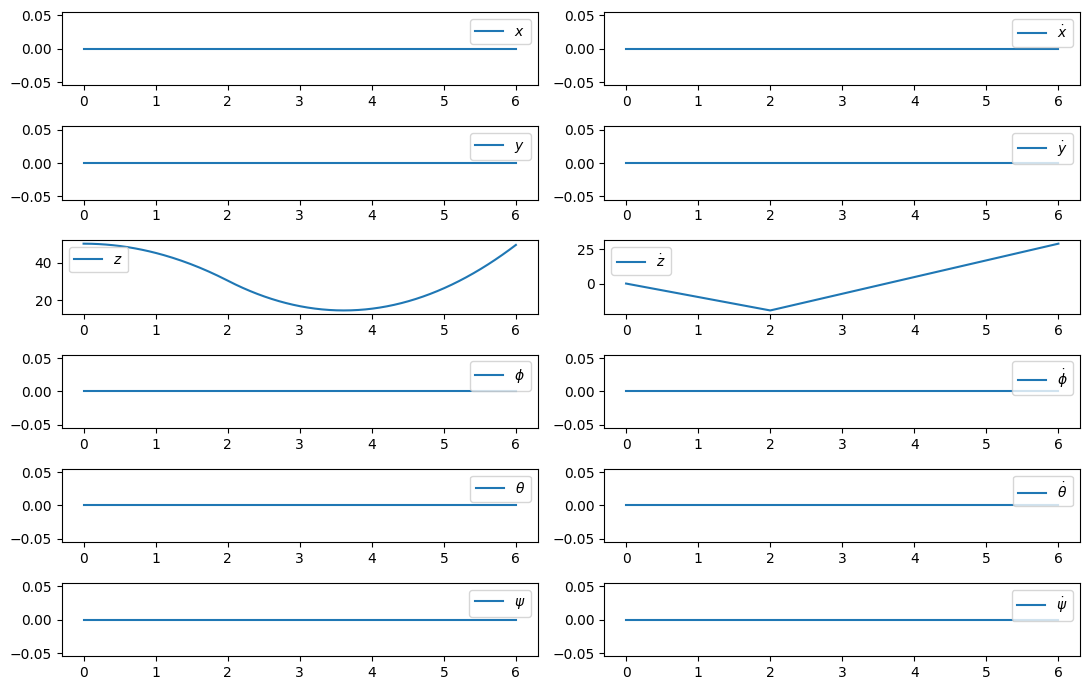

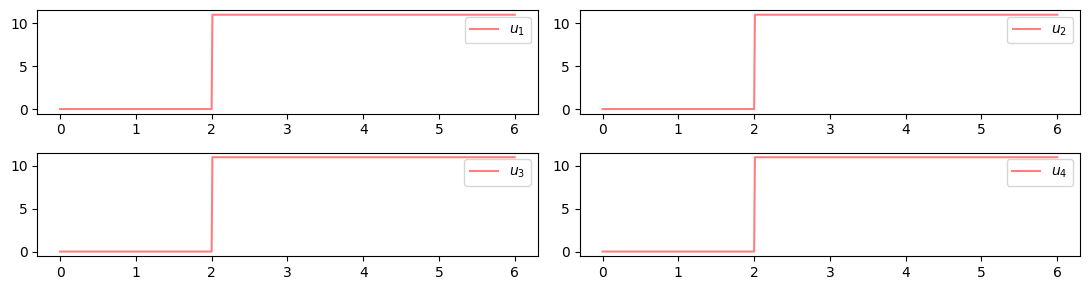

In [6]:
plot_sol(sol)

In [7]:
animate_quadcopter(sol.outputs["state"][:, :6], sol.outputs["state"][:, :6], zlim = [0,50.0], interval=100)

**References**:
> [1] Luukkonen, T., 2011. Modelling and control of quadcopter. Independent research project in applied mathematics, Espoo, 22(22). [Available online.](https://sal.aalto.fi/publications/pdf-files/eluu11_public.pdf)
> 
> [2] Diagram adapted from [this post](https://tex.stackexchange.com/a/637760).